In [23]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from  pathlib import Path


In [24]:
from segmentation_utils.dataloader import (
    ImageCircleDatasetV2,
    ImageCircleDatasetSeperate,
)



In [70]:

def inference_whole_slide(model, slide_pth: Path, max_frame: int):

    image_file_paths = sorted(list(slide_pth.glob("*.jpg")), key=lambda x: int(x.stem))[
        :max_frame
    ]

    images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

    val_dataset = ImageCircleDatasetV2(images, images, images, images, predict=True)

    val_dataloader = DataLoader(val_dataset, batch_size=32)

    model.eval()
    from torch.cuda.amp import autocast

    all_masks = []
    for inpt_images, _ in val_dataloader:
        with torch.no_grad():
            # with autocast():

            pred_mask = model(inpt_images.to(device))
            #
            # masks = torch.softmax(pred_mask,axis=1).cpu().numpy()>0.05
            masks = torch.sigmoid(pred_mask).cpu().numpy() > 0.01

            
            all_masks.extend([msk for msk in masks])
            # breakpoint()

    pn_size = []
    final_images = []
    upscaled_masks = []
    isolated_pns = []
    for pil_img, mask in zip(images[:], all_masks[:]):
        # Ensure the mask is 2D by removing extra dimensions
        # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
        image_ar = np.stack(3 * [np.array(pil_img)])

        upscaled_mask1 = cv2.resize(
            mask[1].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask2 = cv2.resize(
            mask[0].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        # upscaled_mask3 = cv2.resize(
        #     mask[3].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        # )

        # pn_size.append(upscaled_mask.sum())

        upscaled_masks.append((upscaled_mask1, upscaled_mask2))
        image_pn_isolated = image_ar.copy()
        image_pn_isolated[:, ~upscaled_mask1.astype(bool)] = 0
        isolated_pns.append(image_pn_isolated.transpose(1, 2, 0))
        image_ar[0, upscaled_mask1.astype(bool)] = 1
        image_ar[1, upscaled_mask2.astype(bool)] = 1
        # image_ar[2, upscaled_mask3.astype(bool)] = 1

        final_images.append(Image.fromarray(image_ar.transpose(1, 2, 0)))

    return (
        final_images,
        upscaled_masks,
    )


In [71]:
df = pd.read_excel("/home/tsakalis/ntua/phd/pronuclei_detector/data/whole_dna_tsakalis.xlsx")

In [72]:

df['embryo_id'] = df['Slide ID'] + "_"+df['Well'].astype(str)

In [73]:
pth_lib = Path('/media/tsakalis/STORAGE/phd/raw_timelapses')
pth_lib2 = Path("/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses")

In [74]:
def get_slide_ids(pth: Path) -> list[str]:
    return [(x.name, x) for x in list(pth.glob('*'))]



In [75]:
file_avail = pd.DataFrame(get_slide_ids(pth_lib)+get_slide_ids(pth_lib2), columns=['embryo_id', 'pth']).drop_duplicates()

In [76]:
file_avail.drop_duplicates().head(600)

,embryo_id,pth
0,D2017.02.11_S1498_I149_2,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
1,D2016.10.08_S1408_I149_3,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
2,D2017.06.17_S1578_I149_6,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
3,D2017.04.03_S1536_I149_7,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
4,D2016.05.05_S1298_I149_10,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
...,...,...
595,D2019.04.16_S01982_I0149_D_8,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
596,D2016.02.22_S1235_I149_4,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
597,D2017.05.25_S1558_I149_10,/home/tsakalis/ntua/phd/cellforge/cellforge/da...
598,D2017.09.22_S1626_I149_7,/home/tsakalis/ntua/phd/cellforge/cellforge/da...


In [77]:
df['embryo_id'].sample(3)

190        D2017.03.24_S1530_I149_6
153    D2019.04.12_S01977_I0149_D_6
254        D2017.02.01_S1487_I149_1
Name: embryo_id, dtype: object

In [78]:
file_avail.sample(1)

,embryo_id,pth
293,D2017.09.19_S1622_I149_3,/home/tsakalis/ntua/phd/cellforge/cellforge/da...


In [79]:
merged_df = pd.merge(df, file_avail,how='inner', on='embryo_id')

In [80]:
target_column = 'PGT RESULT'

In [81]:
merged_df.shape

(153, 142)

In [82]:
merged_df[target_column].tolist()

['unbalanced',
 'balanced for the translocation, X0',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation/trisomy 21',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation',
 'unbalanced for the translocation, X0',
 'unbalanced for the translocation',
 'monosomy 16/female',
 'monosomy 19/male',
 'monosomy 22',
 'complex mosaic, XXX',
 'trisomy 21',
 '-Xp,monosomy X',
 'nullisomy 15',
 'trisomy 7, monosomy 20',
 'balanced/trisomy 18',
 'unbalanced/complex abnormalities',
 'unbalanced/monosomy 21',
 'monosomy 22',
 'monosomy 21',
 'trisomy 5, monosomy 16, 22',
 'complex abnormalities',
 'monosomy 15, 17',
 'complex abnormalities',
 'monosomy 13',
 'monosomy 16',
 'complex mosaic no et',
 'mosaic monosomy 13 50% no et',
 'partial tr

In [83]:
import re
from collections import defaultdict

def normalize_label(label: str) -> str:
    """
    Normalize and categorize a PGT result label into predefined groups.
    """
    text = label.lower().strip()
    text = re.sub(r'[\s,]+', ' ', text)
    text = re.sub(r'\s?/\s?', '/', text)
    text = text.rstrip('.')
    
    patterns = {
        'Unbalanced translocation': r'unbalanced.*translocation',
        'Balanced translocation': r'balanced.*translocation',
        'Monosomy': r'\bmonosomy\b',
        'Trisomy': r'\btrisomy\b',
        'Mosaic': r'\bmosaic\b',
        'Complex abnormalities': r'complex',
        'Normal/Euploid': r'\b(normal|euploid|no amplif|balanced/euploid)\b',
        'No result': r'no result|no amplification'
    }
    
    for category, pattern in patterns.items():
        if re.search(pattern, text):
            return category
    return 'Other'

def encode_labels(labels):
    """
    Encode each label into a numeric category ID.
    Returns:
      - numeric_labels: List[int] of encoded category IDs
      - mapping: Dict[str, int] mapping category names to IDs
    """
    # Determine unique categories in order of first appearance
    unique_cats = []
    for label in labels:
        cat = normalize_label(label)
        if cat not in unique_cats:
            unique_cats.append(cat)
    
    # Build mapping
    mapping = {cat: idx for idx, cat in enumerate(unique_cats)}
    
    # Encode labels
    numeric_labels = [mapping[normalize_label(label)] for label in labels]
    return numeric_labels, mapping

# Example usage
sample_labels = [
    'unbalanced',
    'balanced for the translocation, X0',
    'monosomy 16/female',
    'trisomy 21',
    'mosaic monosomy 9,22 (70%)',
    'complex mosaic, XXX',
    'normal',
    'no result'
]

encoded, mapping = encode_labels(merged_df[target_column].tolist())
print("Mapping (category -> ID):")
for cat, idx in mapping.items():
    print(f"  {cat}: {idx}")
print("\nEncoded labels:")
print(encoded)


Mapping (category -> ID):
  Other: 0
  Balanced translocation: 1
  Unbalanced translocation: 2
  Monosomy: 3
  Mosaic: 4
  Trisomy: 5
  Complex abnormalities: 6
  Normal/Euploid: 7
  No result: 8

Encoded labels:
[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 5, 3, 0, 3, 5, 6, 3, 3, 3, 3, 6, 3, 6, 3, 3, 4, 3, 5, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 0, 3, 5, 0, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 7, 7, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 3, 3, 1, 2, 2, 2, 2, 0, 2, 2, 2, 6, 6, 3, 3, 1, 1, 2, 5, 2, 2, 2, 2, 3, 3, 5, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 5, 3, 3, 0, 5, 6, 3, 3, 3, 3, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 1, 7, 7, 0, 7, 7, 8, 8]


In [84]:
merged_df['pth'].dropna()

0      /home/tsakalis/ntua/phd/cellforge/cellforge/da...
1      /home/tsakalis/ntua/phd/cellforge/cellforge/da...
2      /home/tsakalis/ntua/phd/cellforge/cellforge/da...
3      /home/tsakalis/ntua/phd/cellforge/cellforge/da...
4      /home/tsakalis/ntua/phd/cellforge/cellforge/da...
                             ...                        
148    /home/tsakalis/ntua/phd/cellforge/cellforge/da...
149    /home/tsakalis/ntua/phd/cellforge/cellforge/da...
150    /home/tsakalis/ntua/phd/cellforge/cellforge/da...
151    /home/tsakalis/ntua/phd/cellforge/cellforge/da...
152    /home/tsakalis/ntua/phd/cellforge/cellforge/da...
Name: pth, Length: 153, dtype: object

In [85]:
weights_pth = Path('/home/tsakalis/Desktop/final_pn_weights/multilabel_dpt-vit_base_patch16_224.augreg_in21k_3_classes_SEPARATE_MASK_FINAL.pt')

In [86]:
import segmentation_models_pytorch as smp
from tqdm import tqdm
from PIL import Image
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
n_classes = 3
model_pronuclei = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )

model_pronuclei.load_state_dict(
        torch.load(
          weights_pth,
            weights_only=True,
        )
    )

<All keys matched successfully>

In [87]:
model_pronuclei.eval()

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [88]:
device='cuda'
model_pronuclei.to(device)

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [122]:



_, masks = inference_whole_slide(model_pronuclei, merged_df['pth'].dropna().iloc[120],200)

100%|██████████| 200/200 [00:00<00:00, 3961.36it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),


In [123]:
import numpy as np
import cv2
from skimage.measure import label, regionprops

def extract_shape_geometry_features(img: np.ndarray):
    """
    Given a 2D uint8 array, threshold at >0, find connected components,
    and return for each blob:
      - centroid (row, col)
      - area
      - perimeter
      - bbox (min_row, min_col, max_row, max_col)
      - aspect_ratio (width/height)
      - convex_hull_coords (Nx2 array of (row, col))
      - eccentricity
      - solidity
      - Hu moments (7,)
    """
    # 1) binarize & label
    binary = img > 0
    labeled = label(binary)

    feats = []

    props = regionprops(labeled)
    if not props:
        feats.append({
            'centroid_row':    None,
            'centroid_col':None,
            'area':None,
            'perimeter':None,
            'bbox':None,
            'aspect_ratio':None,
            'convex_hull':None,   # array of (row,col)
            'eccentricity':None,
            'solidity':None,
            'hu_moments':None            # length-7 array
        })
    for region in props:
        # skip background / tiny
        if region.area < 5:
            feats.append({
            'centroid_row':    None,
            'centroid_col':None,
            'area':None,
            'perimeter':None,
            'bbox':None,
            'aspect_ratio':None,
            'convex_hull':None,   # array of (row,col)
            'eccentricity':None,
            'solidity':None,
            'hu_moments':None            # length-7 array
        })

        # basic
        area = region.area
        perimeter = region.perimeter
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width  = maxc - minc
        aspect_ratio = width / float(height)
        centroid = region.centroid  # (row, col)
        eccentricity = region.eccentricity
        solidity = region.solidity  # area / convex_area

        # convex hull coords via OpenCV
        mask = region.image.astype(np.uint8)  # region-local mask
        # find contours in the small mask
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        hull = cv2.convexHull(cnts[0])
        # convert back to global coords
        # hull is Nx1x2 [[x, y]], where x=col, y=row in local coords
        hull_pts = hull.squeeze()
        hull_global = np.column_stack([
            hull_pts[:,1] + minr,  # row
            hull_pts[:,0] + minc   # col
        ])

        # Hu moments
        m = cv2.moments(mask)
        hu = cv2.HuMoments(m).flatten()

        feats.append({
            'centroid_row':    centroid[0],
            'centroid_col':    centroid[1],
            'area':            area,
            'perimeter':       perimeter,
            'bbox':            (minr, minc, maxr, maxc),
            'aspect_ratio':    aspect_ratio,
            'convex_hull':     hull_global,   # array of (row,col)
            'eccentricity':    eccentricity,
            'solidity':        solidity,
            'hu_moments':      hu            # length-7 array
        })

    return feats[-1]

In [124]:
pn1_features = [extract_shape_geometry_features(msk[0]) for msk in masks]
pn2_features = [extract_shape_geometry_features(msk[1]) for msk in masks]

<Axes: >

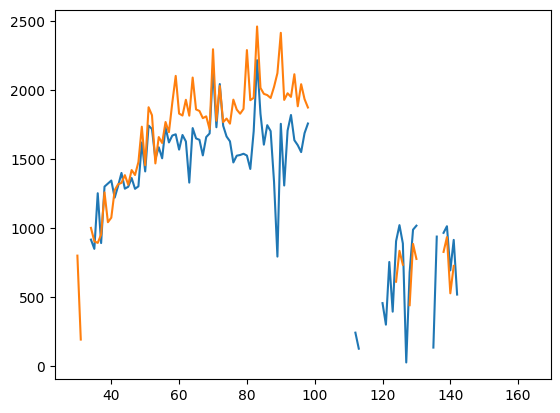

In [125]:
pd.DataFrame(pn1_features)['area'].plot()
pd.DataFrame(pn2_features)['area'].plot()

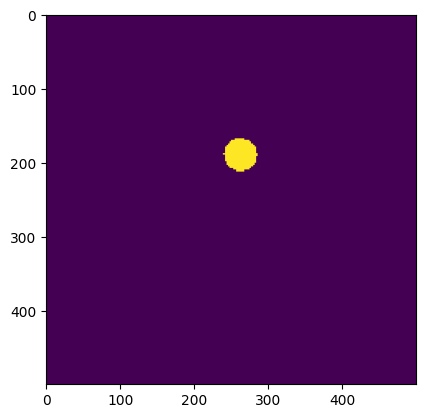

In [93]:
import matplotlib.pyplot as plt
plt.imshow(masks[83][1])